In [138]:
import os
from datetime import datetime, timedelta
from enum import Enum
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [387]:
###
# Utils for mlflow artifacts
###
class MlflowConfig:
    tracking_uri = '../mlruns'
    experiment_id = '12'
    eval_run_ids = {
        'rain_only': 'fe8315b263294e9a856d83d4eb4ac136',
        'rain_temp_humid': '26257fd09cb84827a1f29064d2e02a7a'
    }
    eval_artifact_dir = 'evaluations'
    reuse_predict_eval_dir = 'model/sequential_evaluation/reuse_predict'
    metrics_csv = 'predict_metrics.csv'
    result_csv = 'predict_result.csv'


mlflow_client = mlflow.MlflowClient(MlflowConfig.tracking_uri)

def get_artifact_path(run_id):
    artifact_location = mlflow_client.get_experiment(MlflowConfig.experiment_id).artifact_location
    return artifact_location.replace('file://', '')

def get_eval_artifacts_dir(run_id):
    return os.path.join(get_artifact_path(run_id), run_id, 'artifacts', MlflowConfig.eval_artifact_dir)

def get_metrics_df(run_id):
    eval_artifacts_path = get_eval_artifacts_dir(run_id)
    return pd.read_csv(os.path.join(eval_artifacts_path, MlflowConfig.reuse_predict_eval_dir, MlflowConfig.metrics_csv))

def get_result_df(run_id):
    eval_artifacts_path = get_eval_artifacts_dir(run_id)
    return pd.read_csv(os.path.join(eval_artifacts_path, MlflowConfig.reuse_predict_eval_dir, MlflowConfig.result_csv))

def get_max_rainfalls_per_case(run_id):
    pred_df = get_result_df(run_id)
    results = {'test_case_name': [], 'predict_utc_time': [], 'max_rainfall': []}
    for (case_name, pred_utc_time), df in pred_df.groupby(by=['test_case_name', 'predict_utc_time']):
        results['test_case_name'].append(case_name)
        results['predict_utc_time'].append(pred_utc_time)
        results['max_rainfall'].append(df['hour-rain'].max())
    return pd.DataFrame(results)

def get_metrics_with_maxrainfall(run_id):
    metrics_df = get_metrics_df(run_id)
    max_rainfall = get_max_rainfalls_per_case(run_id)
    metrics_df = pd.merge(metrics_df, max_rainfall, how='left', left_on=['test_case_name', 'predict_utc_time'], right_on=['test_case_name', 'predict_utc_time'])
    return metrics_df[['test_case_name', 'predict_utc_time', 'rmse', 'max_rainfall']].sort_values(by='max_rainfall', ascending=False)


###
# Utils for testcase
###
class TargetCases:
    good_case_names = ['TC_case_2020-10-12_8-0_start', 'NOT_TC_case_2019-10-12_8-40_start']
    bad_case_names = ['TC_case_2020-09-14_5-0_start', 'TC_case_2020-10-12_7-0_start']


class WeatherParams(str, Enum):
    rainfall = 'rainfall'
    temperature = 'temperature'
    humidity = 'humidity'

    @classmethod
    def valid(self, param: str):
        if param not in WeatherParams._member_names_:
            raise ValueError(f'Use params in {WeatherParams._member_names_} instead of {param}')

    @classmethod
    def unit(self, param: str):
        WeatherParams.valid(param)

        if param == WeatherParams.rainfall:
            return 'mm/h'
        elif param == WeatherParams.temperature:
            return '℃'
        else:
            return '%'

    @classmethod
    def min(self, param: str):
        WeatherParams.valid(param)

        if param == WeatherParams.rainfall:
            return 0
        elif param == WeatherParams.temperature:
            return 20
        else:
            return 30
    
    @classmethod
    def max(self, param: str):
        WeatherParams.valid(param)
        
        if param == WeatherParams.rainfall:
            return 100
        elif param == WeatherParams.temperature:
            return 40
        else:
            return 90

    @classmethod
    def get_cmap(self, param: str):
        WeatherParams.valid(param)
        
        if param == WeatherParams.rainfall:
            cmap_data = [
                (1.0, 1.0, 1.0),
                (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                (0.0, 1.0, 1.0),
                (0.0, 0.8784313797950745, 0.501960813999176),
                (0.0, 0.7529411911964417, 0.0),
                (0.501960813999176, 0.8784313797950745, 0.0),
                (1.0, 1.0, 0.0),
                (1.0, 0.627451002597808, 0.0),
                (1.0, 0.0, 0.0),
                (1.0, 0.125490203499794, 0.501960813999176),
                (0.9411764740943909, 0.250980406999588, 1.0),
                (0.501960813999176, 0.125490203499794, 1.0),
            ]
            return mcolors.ListedColormap(cmap_data, "precipitation") 
        elif param == WeatherParams.temperature:
            return plt.cm.inferno
        else:
            return plt.cm.Greens

    @classmethod
    def get_clevels(self, param: str):
        WeatherParams.valid(param)
        
        if param == WeatherParams.rainfall:
            return [0, 5, 7.5, 10, 15, 20, 30, 40, 50, 70, 100]
        elif param == WeatherParams.temperature:
            return [i for i in range(WeatherParams.min(param), WeatherParams.max(param), 1)]
        else:
            return [i for i in range(WeatherParams.min(param), WeatherParams.max(param), 2)]

def datetime_range(start: datetime, end: datetime, delta: timedelta):
    current = start
    while current <= end:
        yield current
        current += delta


def timestep_names(year: int = 2020, month: int = 1, date: int = 1, delta: int = 10) -> list[str]:
    dts = [
        f"{dt.hour}-{dt.minute}"
        for dt in datetime_range(datetime(year, month, date, 0), datetime(year, month, date, 23, 59), timedelta(minutes=delta))
    ]
    return dts


class TestCase:
    data_root_dir = '../../poteka-sample-data/'
    datafile_fmt = 'csv'
    predictfile_fmt = 'parquet.gzip'
    def __init__(self, test_case_name: str, input_seq_length: int = 6, label_seq_length: int = 6, timestep_delta: int = 10, run_id = None) -> None:
        self.run_id = run_id
        if run_id is not None:
            self.mlflow_artifact_dir = get_eval_artifacts_dir(run_id)
        self.test_case_name = test_case_name
        self.input_seq_length = input_seq_length
        self.label_seq_length = label_seq_length
        self.parsed_test_case_name = self._parse_test_case_name()
        self.timestep_names = timestep_names(delta=timestep_delta)

    @property
    def date(self) -> str:
        return self.parsed_test_case_name['date']
    @property
    def start_time(self) -> str:
        return self.parsed_test_case_name['start_time']
    
    @property
    def input_times(self) -> list[str]:
        start_time_idx = self.timestep_names.index(self.start_time)
        return self.timestep_names[start_time_idx - self.input_seq_length:start_time_idx]

    @property
    def pred_times(self) -> list[str]:
        start_time_idx = self.timestep_names.index(self.start_time)
        return self.timestep_names[start_time_idx:start_time_idx + self.label_seq_length]

    @property
    def data_pathes(self) -> dict:
        paths = {}
        paths['oneday_data'] = {
            'input': [os.path.join(self.data_root_dir, 'oneday_data', self.date,  f'{f}.{self.datafile_fmt}') for f in self.input_times],
            'label': [os.path.join(self.data_root_dir, 'oneday_data', self.date,  f'{f}.{self.datafile_fmt}') for f in self.pred_times],
        }
        for param in WeatherParams._member_names_:
            paths[param] = {
                'input': [os.path.join(self.data_root_dir, param, self.date, f'{f}.{self.datafile_fmt}') for f in self.input_times],
                'label': [os.path.join(self.data_root_dir, param, self.date, f'{f}.{self.datafile_fmt}') for f in self.pred_times],
            }
            if param == WeatherParams.rainfall and self.run_id is not None:
                paths[param].update({
                    'predict': [
                        os.path.join(self.mlflow_artifact_dir, MlflowConfig.reuse_predict_eval_dir, self.test_case_name, f'{f}.{self.predictfile_fmt}') for f in self.pred_times
                    ]
                })
        return paths

    @property
    def result_df(self):
        if self.run_id is None:
            raise ValueError('set run_id to get result_df')
        df = get_result_df(self.run_id)
        return df.loc[df.test_case_name == self.test_case_name]
    
    @property
    def metrrics_df(self):
        if self.run_id is None:
            raise ValueError('set run_id to get metrics_df')
        return get_metrics_df(self.run_id)


    def _parse_test_case_name(self) -> dict:
        split_by_underscore = self.test_case_name.split('_')
        if self._is_tc_case():
            return {'date': split_by_underscore[2], 'start_time': split_by_underscore[3]}
        else:
            return {'date': split_by_underscore[3], 'start_time': split_by_underscore[4]}

    def _is_tc_case(self):
        return self.test_case_name.startswith('TC')


###
# tests
###
test_case = TestCase(TargetCases.good_case_names[0], run_id=MlflowConfig.eval_run_ids['rain_only'])
for item in test_case.data_pathes.values():
    for paths in item.values():
        is_exist = [os.path.exists(p) for p in paths]
        assert all(is_exist)

AssertionError: 

In [297]:
###
# Utils for poteka data
###
class TargetManilaErea:
    MAX_LONGITUDE = 121.150
    MIN_LONGITUDE = 120.90

    MAX_LATITUDE = 14.760
    MIN_LATITUDE = 14.350


def create_img_from_griddata(ax, grid_data, color_levels, color_map, contour: bool = False):
    grid_lon = np.round(np.linspace(TargetManilaErea.MIN_LONGITUDE, TargetManilaErea.MAX_LONGITUDE), decimals=3)
    grid_lat = np.round(np.linspace(TargetManilaErea.MIN_LATITUDE, TargetManilaErea.MAX_LATITUDE), decimals=3)

    # fig = plt.figure(figsize=(7, 8), dpi=80)
    # ax = fig.add_subplot(1, 1, 1)

    xi, yi = np.meshgrid(grid_lon, grid_lat)
    if contour:
        # Add contour lines
        ax.contour(xi, np.flip(yi), grid_data, colors=['black'])

    # Add heat map
    cs = ax.contourf(
        xi, np.flip(yi), grid_data, color_levels, cmap=color_map, norm=mcolors.BoundaryNorm(color_levels, color_map.N)
    )
    return cs


class DetectAbnormalPoint:
    def __init__(self, data):
        self.before_data = None

    def check(new_data):
        return


def visualize_timeseries_change(test_case_name, target_params = None):
    if target_params == None:
        target_params = WeatherParams._member_names_

    if isinstance(target_params, str):
        target_params = [target_params]

    test_case = TestCase(test_case_name)
    input_seq_length = test_case.input_seq_length
    data_paths = test_case.data_pathes
    # fig, axes = plt.subplots(len(target_params), input_seq_length, figsize=(30, 20))
    fig = plt.figure(constrained_layout=True, figsize=(30, 20))
    fig.suptitle('{} Case'.format(test_case.date.replace('-', '/')), fontsize=20)
    subfigs = fig.subfigures(nrows=len(target_params), ncols=1)
    for row, subfig in enumerate(subfigs):
        param_name = target_params[row]
        subfig.suptitle(param_name, fontsize=20)

        axs = subfig.subplots(nrows=1, ncols=input_seq_length)
        for col, ax in enumerate(axs):
            df = pd.read_csv(data_paths[param_name]['input'][col], index_col=0)
            cs = create_img_from_griddata(ax, df.to_numpy(), WeatherParams.get_clevels(param_name), WeatherParams.get_cmap(param_name), contour=False if param_name == WeatherParams.rainfall else True)

            # Add time step
            if row + 1 == len(target_params):
                time_step = test_case.input_times[col].replace('-', ':')
                if time_step.endswith(':0'):
                    time_step = time_step.replace(':0', ':00')
                ax.set_xlabel(f'{time_step} UTC', fontsize=20)
        cbar = plt.colorbar(cs)
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label(WeatherParams.unit(param_name), fontsize=20)

    plt.show()
    plt.close()


def visualize_pred_vs_label(test_case_name):
    suptitle_fontsize = 20
    cbar_labeltext_size = 15
    input_seq_length = 6

    test_case = TestCase(test_case_name)
    fig = plt.figure(constrained_layout=True, figsize=(30, 20))
    fig.suptitle('{} Case'.format(test_case.date.replace('-', '/')), fontsize=20)
    subfigs = fig.subfigures(nrows=3, ncols=1) # observation, rain only, rain_temp_humid
    for row, subfig in enumerate(subfigs):
        if row == 0:
            subfig.suptitle('Observation', fontsize=suptitle_fontsize)
            data_paths = test_case.data_pathes[WeatherParams.rainfall]['label']
        elif row == 1:
            subfig.suptitle('Prediction of the model trained with rainfall, temperature and humidity.', fontsize=suptitle_fontsize)
            data_paths = TestCase(test_case_name, run_id=MlflowConfig.eval_run_ids['rain_temp_humid']).data_pathes[WeatherParams.rainfall]['predict']
        else:
            subfig.suptitle('Prediction of the model trained with only rainfall', fontsize=suptitle_fontsize)
            data_paths = TestCase(test_case_name, run_id=MlflowConfig.eval_run_ids['rain_only']).data_pathes[WeatherParams.rainfall]['predict']
        
        axs = subfig.subplots(nrows=1, ncols=input_seq_length)
        for col, ax in enumerate(axs):
            if row == 0:
                data = pd.read_csv(data_paths[col], index_col=0).to_numpy()
            else:
                data = pd.read_parquet(data_paths[col]).to_numpy()
            cs = create_img_from_griddata(ax, data, WeatherParams.get_clevels(WeatherParams.rainfall), WeatherParams.get_cmap(WeatherParams.rainfall))

            # Add time step
            if row + 1 == 3:
                time_step = test_case.pred_times[col].replace('-', ':')
                if time_step.endswith(':0'):
                    time_step = time_step.replace(':0', ':00')
                ax.set_xlabel(f'{time_step} UTC', fontsize=20)
        cbar = plt.colorbar(cs)
        cbar.ax.tick_params(labelsize=cbar_labeltext_size)
        cbar.set_label(WeatherParams.unit(WeatherParams.rainfall), fontsize=suptitle_fontsize)
    plt.show()
    plt.close()

In [385]:
###
# Data Cleaning
###
def get_zero_diff_count(series: pd.Series):
    return (series == 0).sum()

def check_abnormal_datapoint(data_df):
    y_labels = {
        "hour-rain": "Hourly rainfall (mm/h)",
        "AT1": "Temperature (℃)",
        "RH1": "Relative Humidity (%)",
        "WS1": "Wind Speed (m/s)",
        "V-Wind": "North-south wind speed(m/s)",
        "U-Wind": "East-west wind speed (m/s)",
        "PRS": "Station Pressure (hPa)",
    }
    for col in ['AT1', 'RH1']:
        if col in list(y_labels.keys()):
            # Check outliers
            ## 1. same value is continuing (except for hour-rain)
            grouped_by_station = data_df.groupby(by=["Station_Name"])
            if col != "hour-rain":
                check_same_value_df = data_df.sort_values(by=["Station_Name", "time_step"])
                check_same_value_df["diff"] = check_same_value_df.groupby(by=["Station_Name"])[col].diff()
                zero_diff_count_series = check_same_value_df.groupby(by=["Station_Name"])["diff"].agg(get_zero_diff_count)
                for observation_name in zero_diff_count_series.index:
                    zero_diff_count = zero_diff_count_series[observation_name]
                    if zero_diff_count > 50:
                        print(f"{col} data of {observation_name} has {zero_diff_count} zero different values.")

# TODO
# 1. Replace Abnormal value with mean of near 3,4 points value. calculate distance from longitude and latitude.
# 2. interpolate, use interpolator from evaluate
# 3. visualize!!
from scipy.interpolate import RBFInterpolator
import sys
sys.path.append('../')
from common.config import PPOTEKACols, MinMaxScalingValue
from evaluate.src.interpolator.humidity_interpolator import HumidityInterplator
from evaluate.src.interpolator.temperature_interpolator import TemperatureInterpolator

def interpolate(df: pd.DataFrame, param_name: str, exclude_obpoints: list = ['Vlz-Bagbaguin_00174731']): # 'MM-EFCOS_00173456', 
    WeatherParams.valid(param_name)
    df = df.loc[~df['Station_Name'].isin(exclude_obpoints)]
    obpoint_lons, obpoint_lats = df['LON'].tolist(), df['LAT'].tolist()
    target_col = PPOTEKACols.get_col_from_weather_param(param_name)

    min_val, max_val = MinMaxScalingValue.get_minmax_values_by_ppoteka_cols(target_col)
    data = (df[target_col].to_numpy() - min_val) / (max_val - min_val)
    rbfi = RBFInterpolator(
        y=np.column_stack([obpoint_lons, obpoint_lats]), d=data, kernel="linear", epsilon=10
    )
    grid_coordinate = np.mgrid[120.90:121.150:50j, 14.350:14.760:50j]

    y_pred = rbfi(grid_coordinate.reshape(2, -1).T)
    grid_data = np.reshape(y_pred, (50, 50)).T
    grid_data = np.flipud(grid_data)

    grid_data = np.where(grid_data > 0, grid_data, 0)
    grid_data = np.where(grid_data > 1, 1, grid_data)

    return grid_data.astype(np.float32) * (max_val - min_val) + min_val


def visualize_interpolate_bf_af(test_case_name: str, run_id: str, target_param: str):
    WeatherParams.valid(target_param)

    test_case = TestCase(test_case_name, run_id=run_id)
    input_seq_length = test_case.input_seq_length
    data_paths = test_case.data_pathes
    # fig, axes = plt.subplots(len(target_params), input_seq_length, figsize=(30, 20))
    fig = plt.figure(constrained_layout=True, figsize=(25, 14))
    fig.suptitle('{} Case [{}]'.format(test_case.date.replace('-', '/'), target_param), fontsize=20)
    subfigs = fig.subfigures(nrows=2, ncols=1)
    for row, subfig in enumerate(subfigs):
        if row == 0:
            suptitle = 'before'
        else:
            suptitle = 'after'
        subfig.suptitle(suptitle, fontsize=20)

        axs = subfig.subplots(nrows=1, ncols=input_seq_length)
        for col, ax in enumerate(axs):
            if row == 0:
                data = pd.read_csv(data_paths[target_param]['input'][col], index_col=0).to_numpy()
            else:
                # results_df = test_case.result_df.rename(columns={'Unnamed: 0': 'Station_Name'})
                oneday_df = pd.read_csv(test_case.oneday_data_pathes['input'][col])
                data = interpolate(oneday_df, param_name=target_param)
            cs = create_img_from_griddata(ax, data, WeatherParams.get_clevels(target_param), WeatherParams.get_cmap(target_param), contour=False if target_param == WeatherParams.rainfall else True)

            # Add time step
            if row == 1:
                time_step = test_case.pred_times[col].replace('-', ':')
                if time_step.endswith(':0'):
                    time_step = time_step.replace(':0', ':00')
                ax.set_xlabel(f'{time_step} UTC', fontsize=20)
        cbar = plt.colorbar(cs)
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label(WeatherParams.unit(target_param), fontsize=20)

    plt.show()
    plt.close()

TC_case_2020-10-12_7-0_start


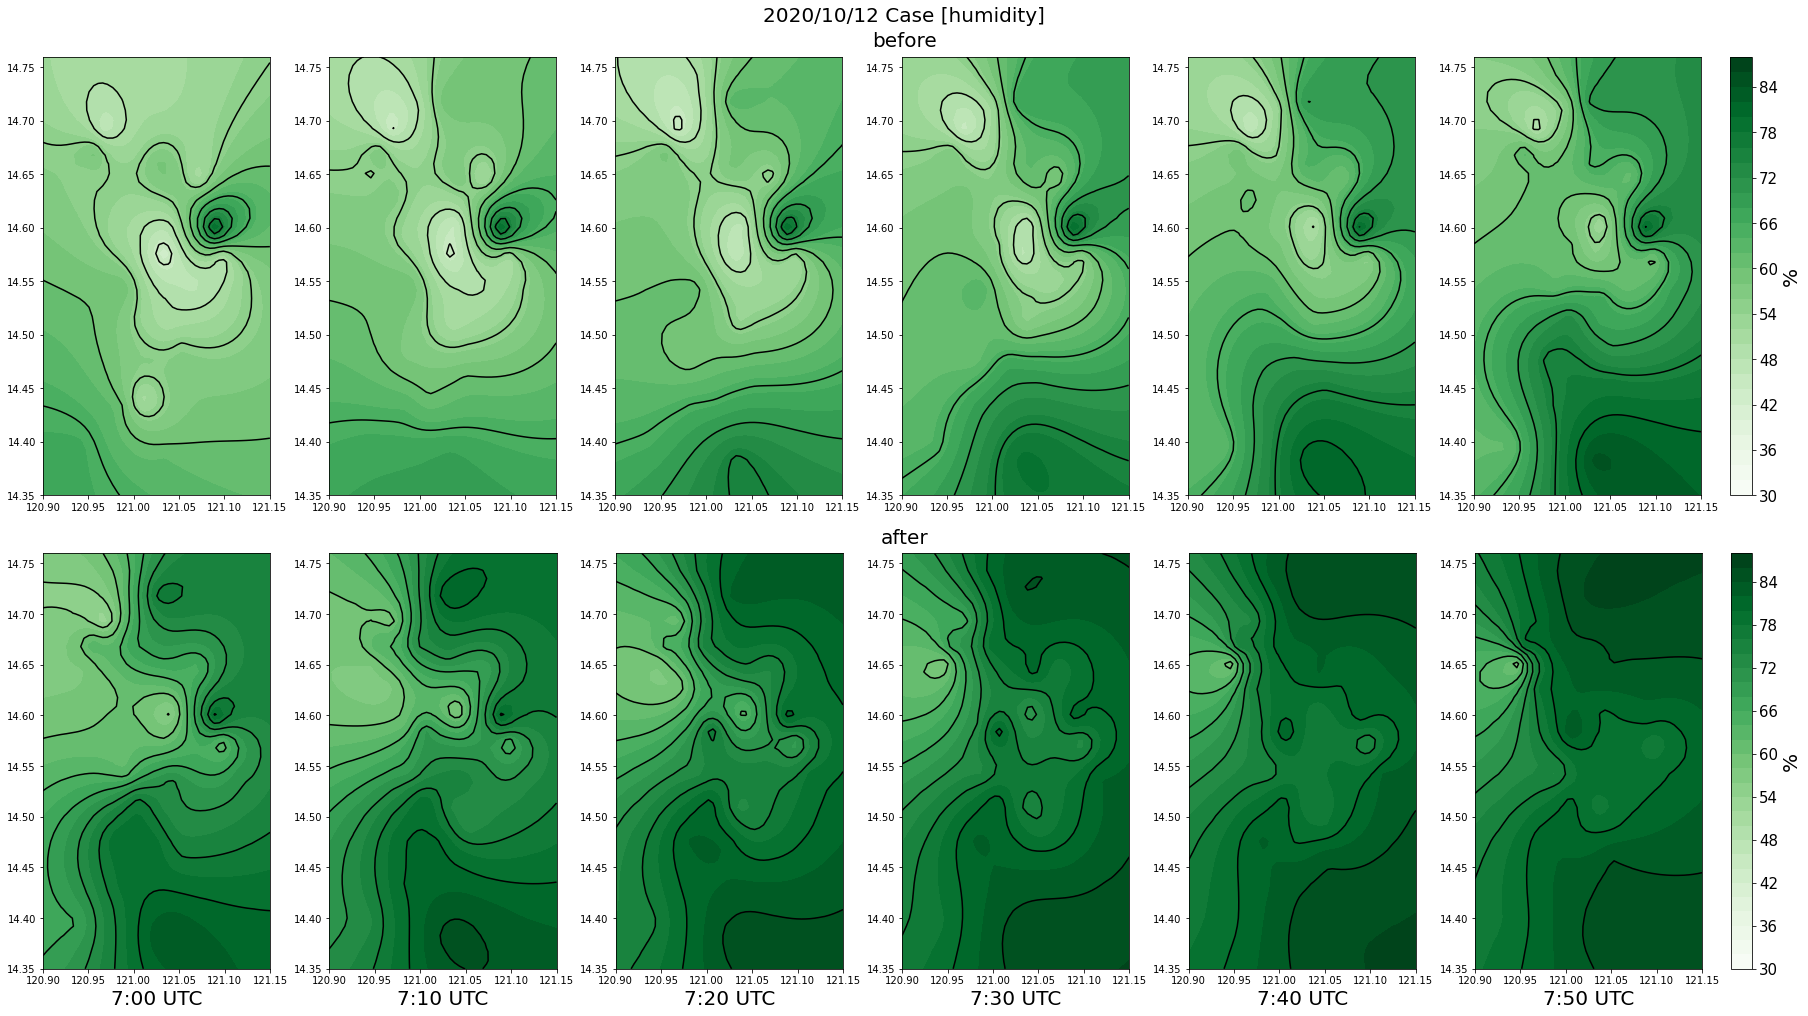

In [386]:
test_case_name = TargetCases.bad_case_names[1]
print(test_case_name)
visualize_interpolate_bf_af(test_case_name, MlflowConfig.eval_run_ids['rain_only'], target_param=WeatherParams.humidity)

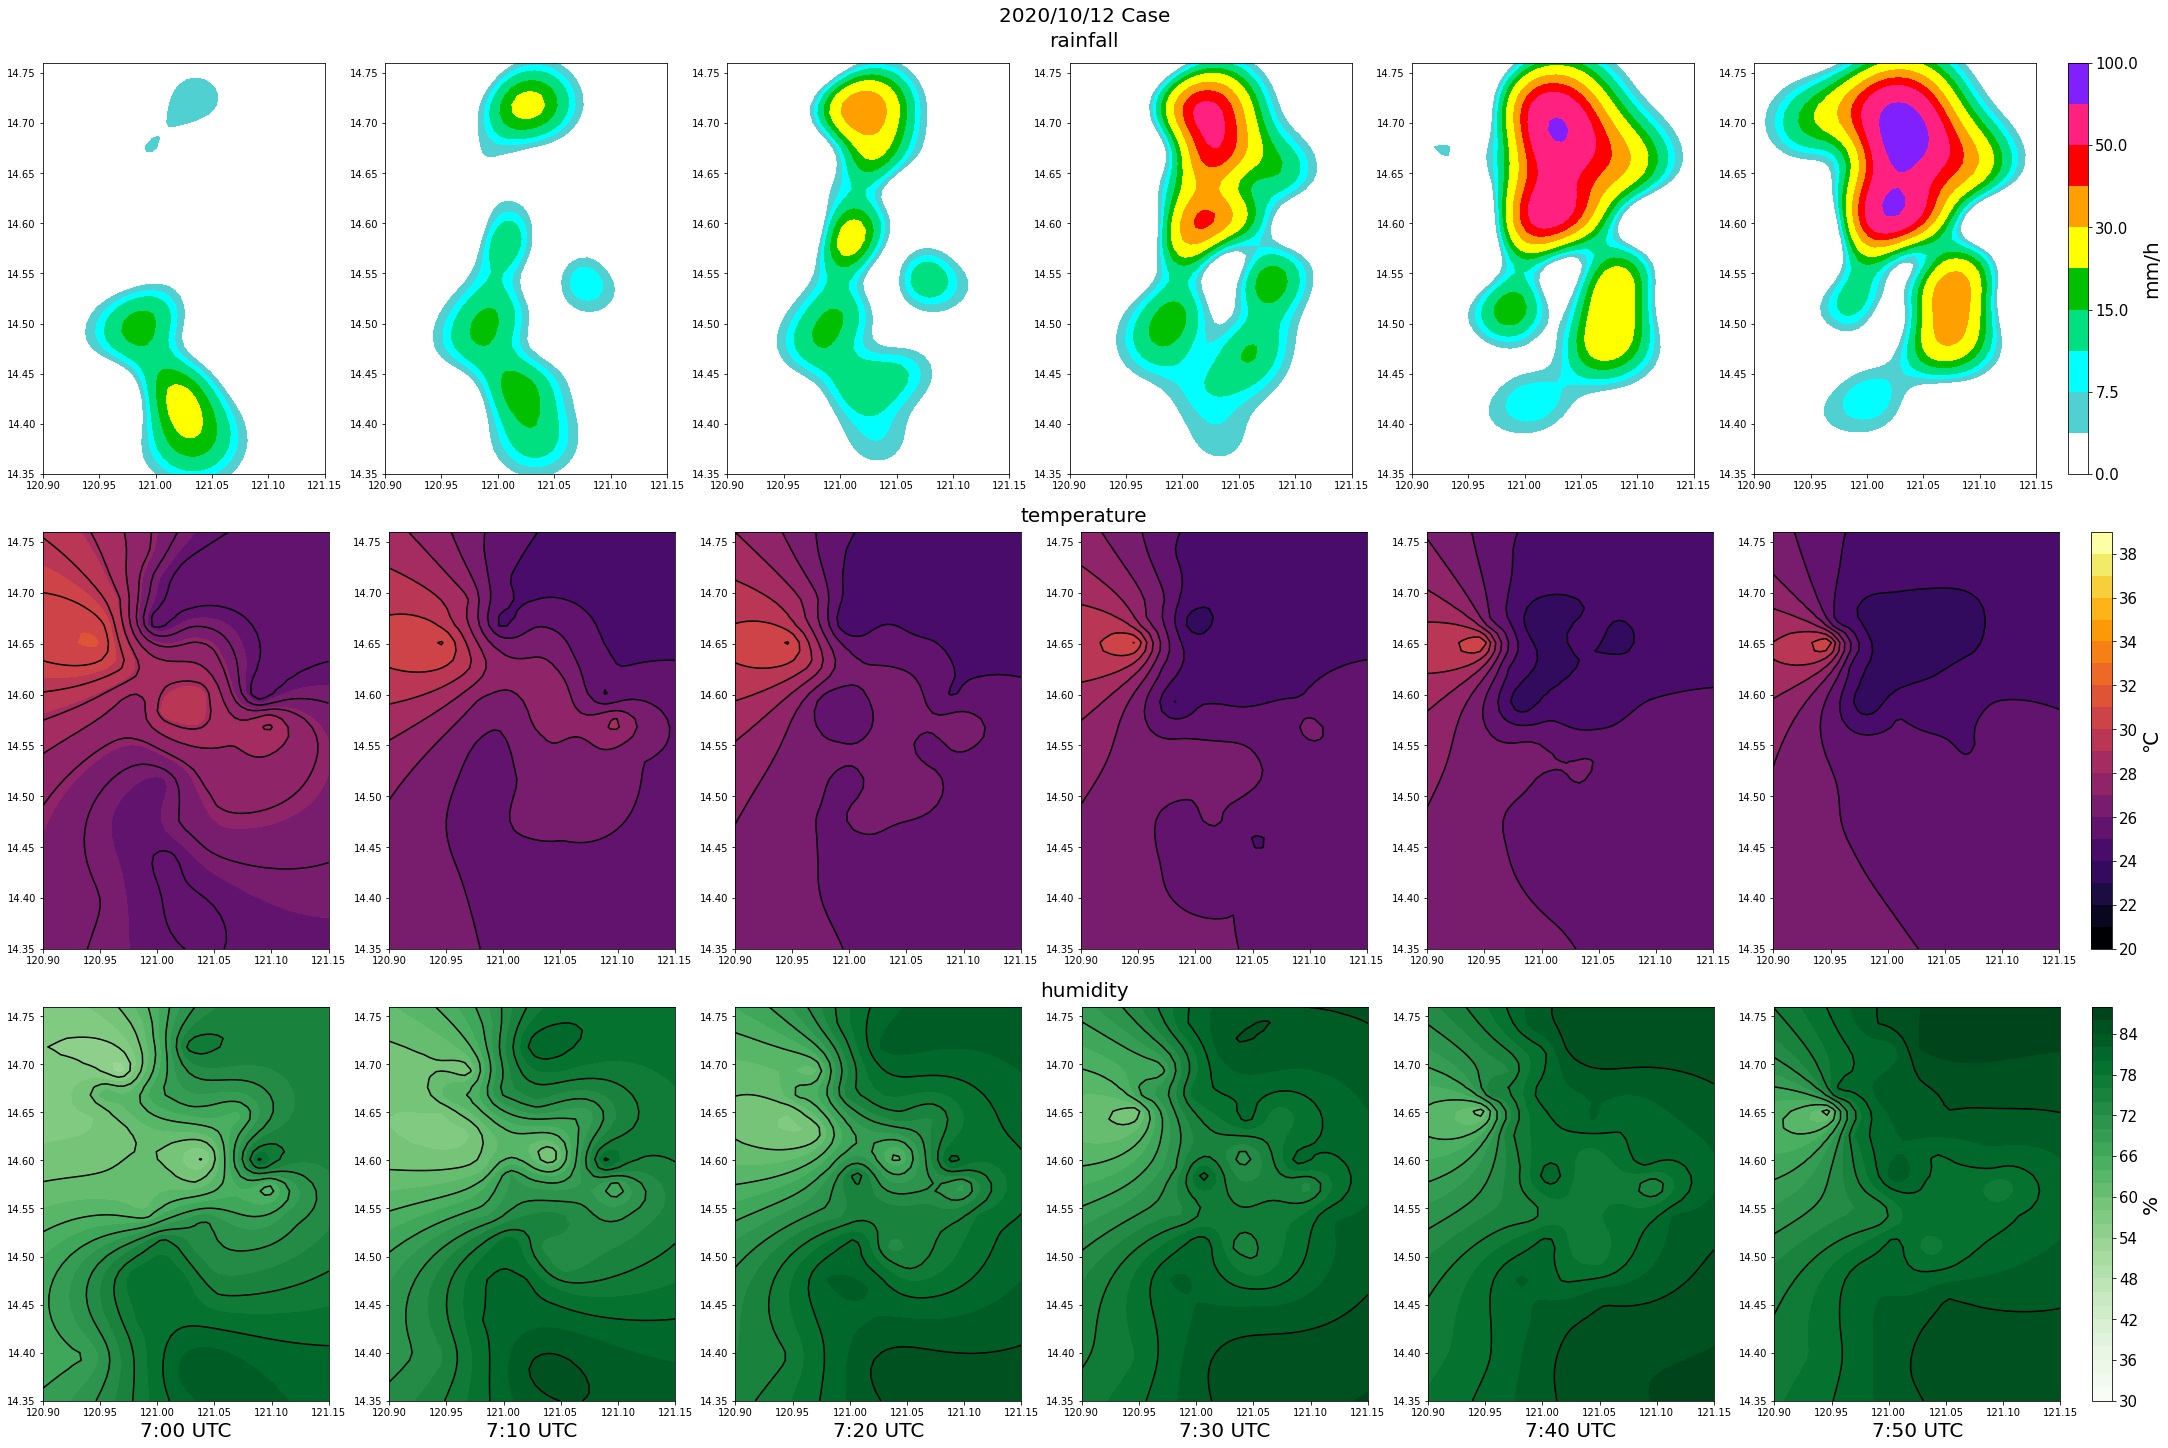

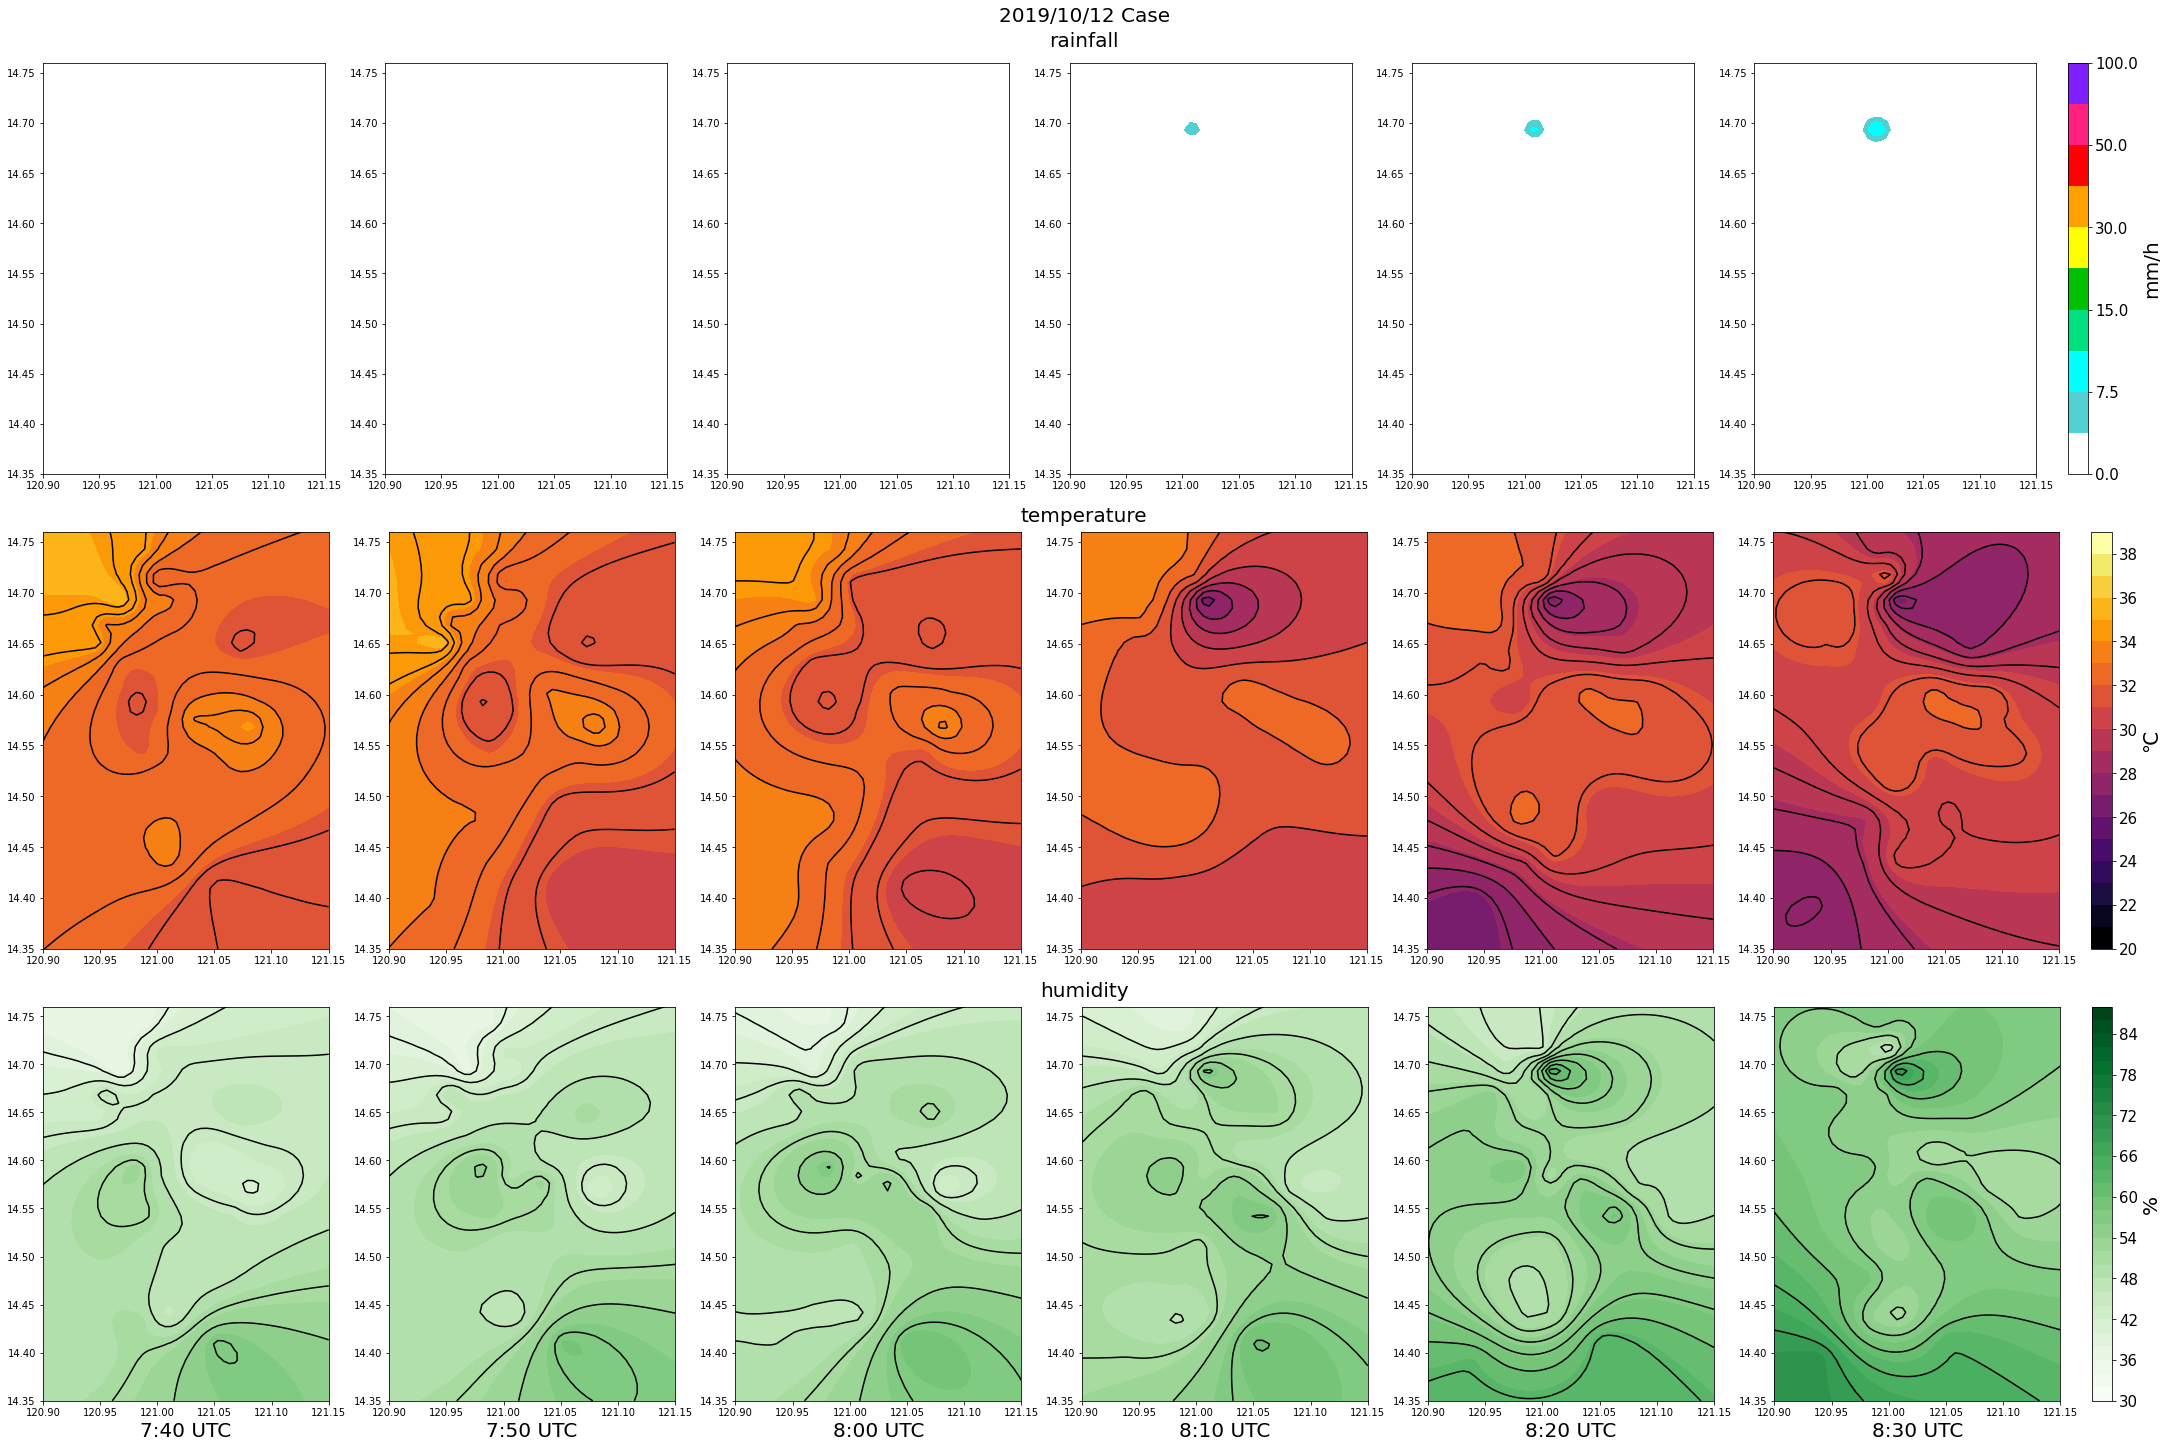

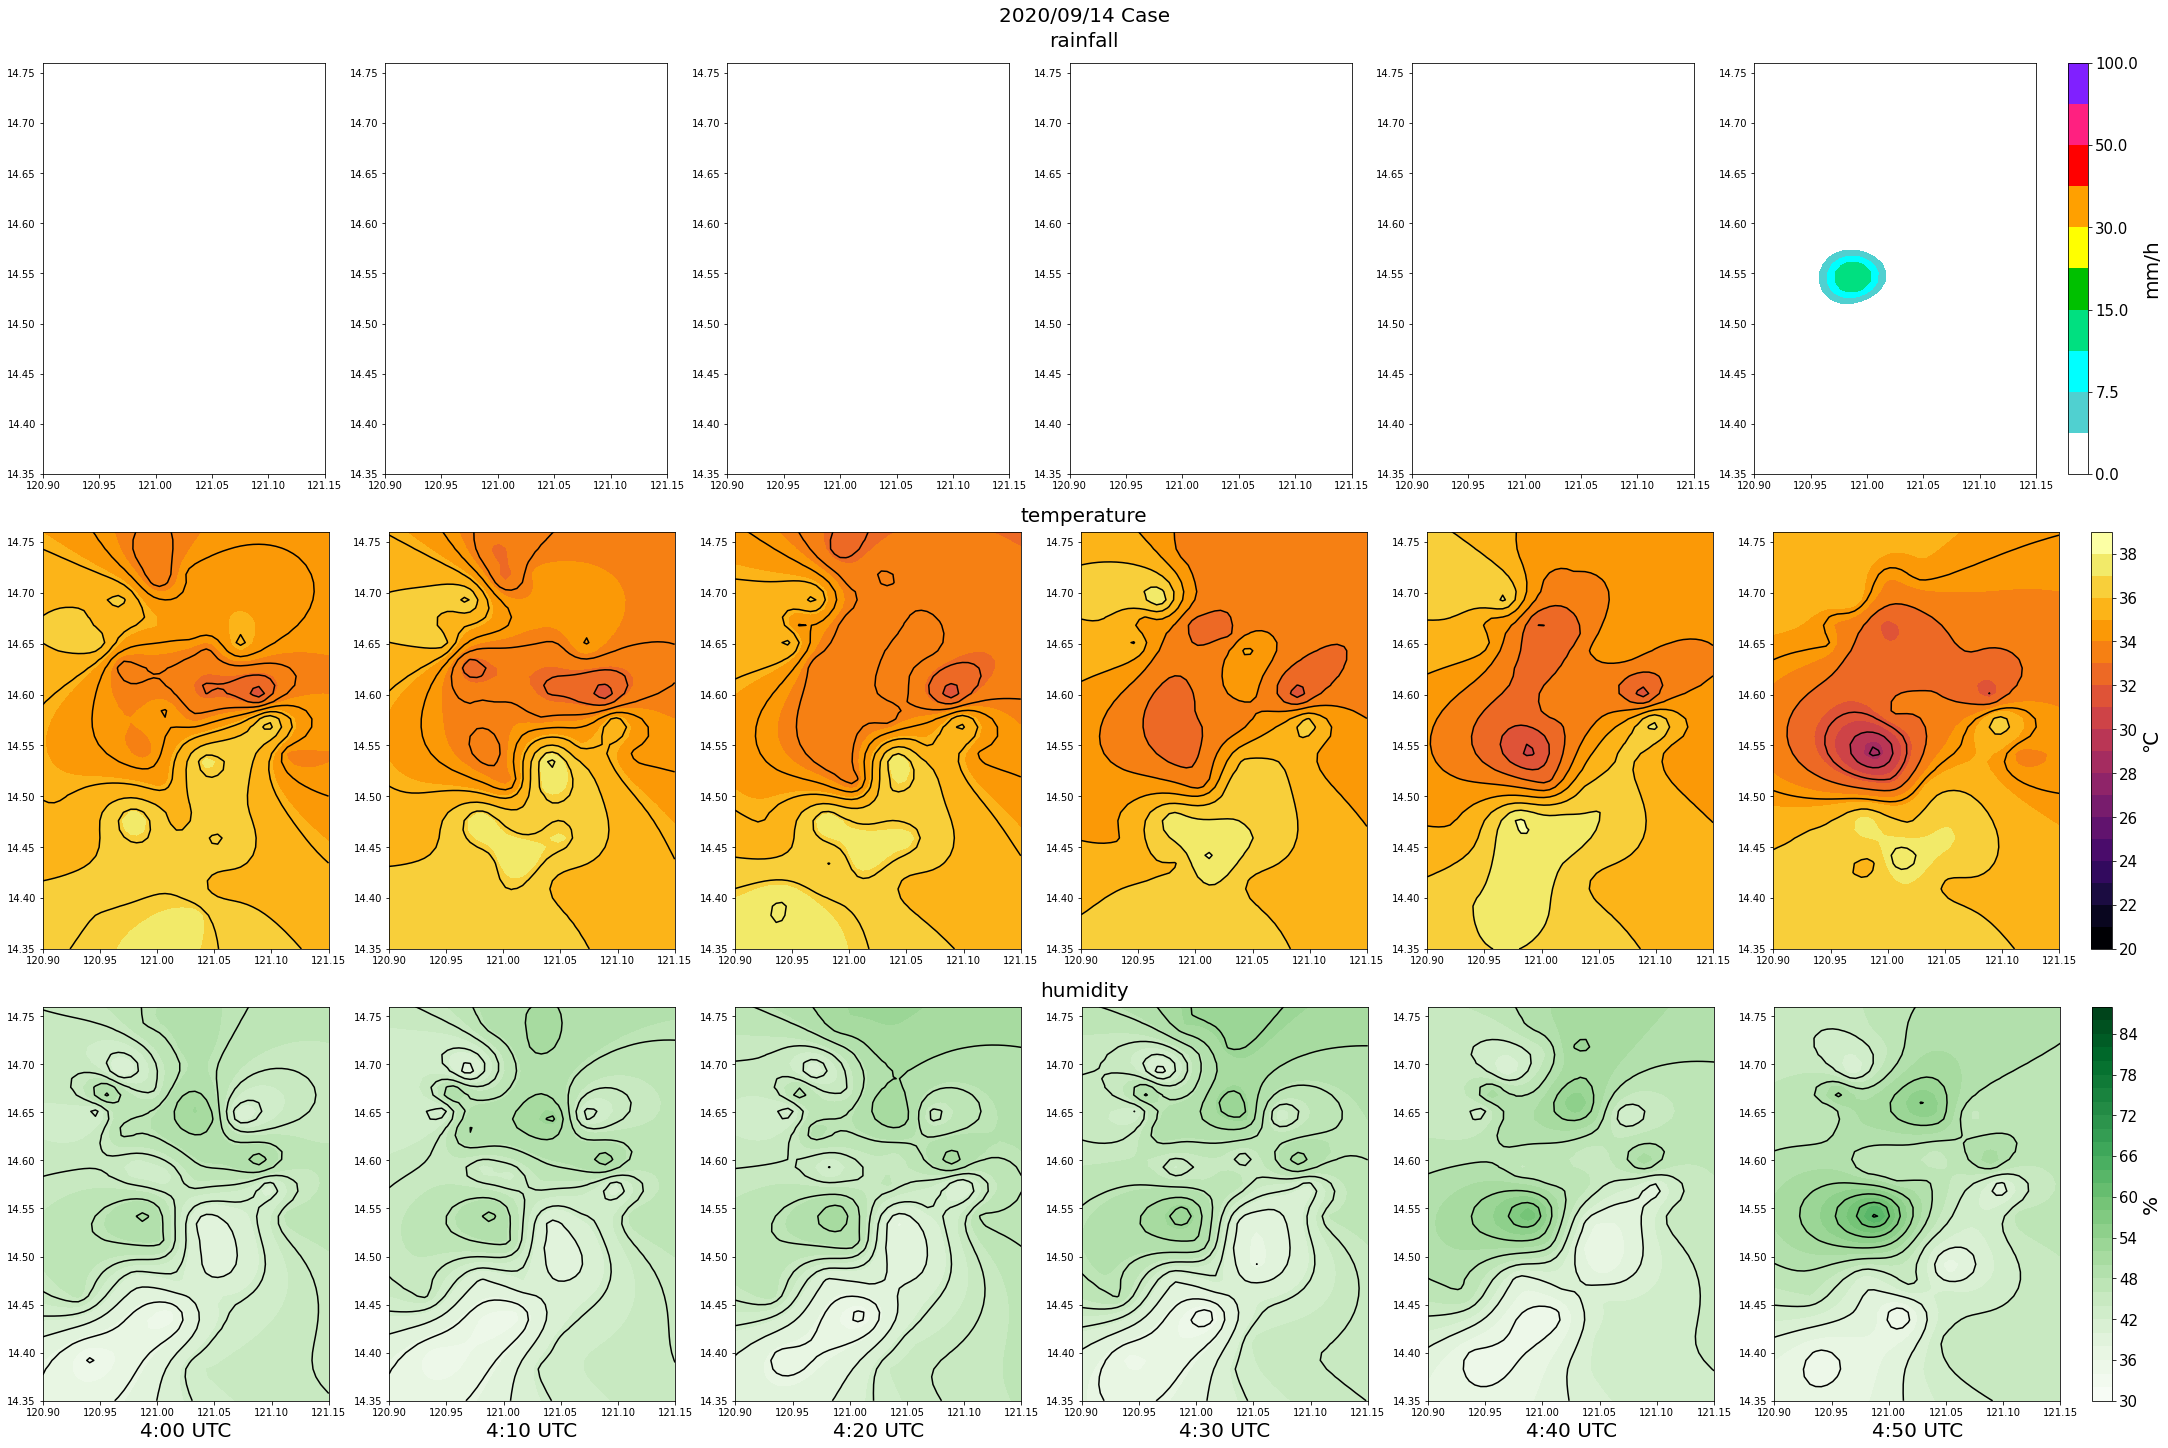

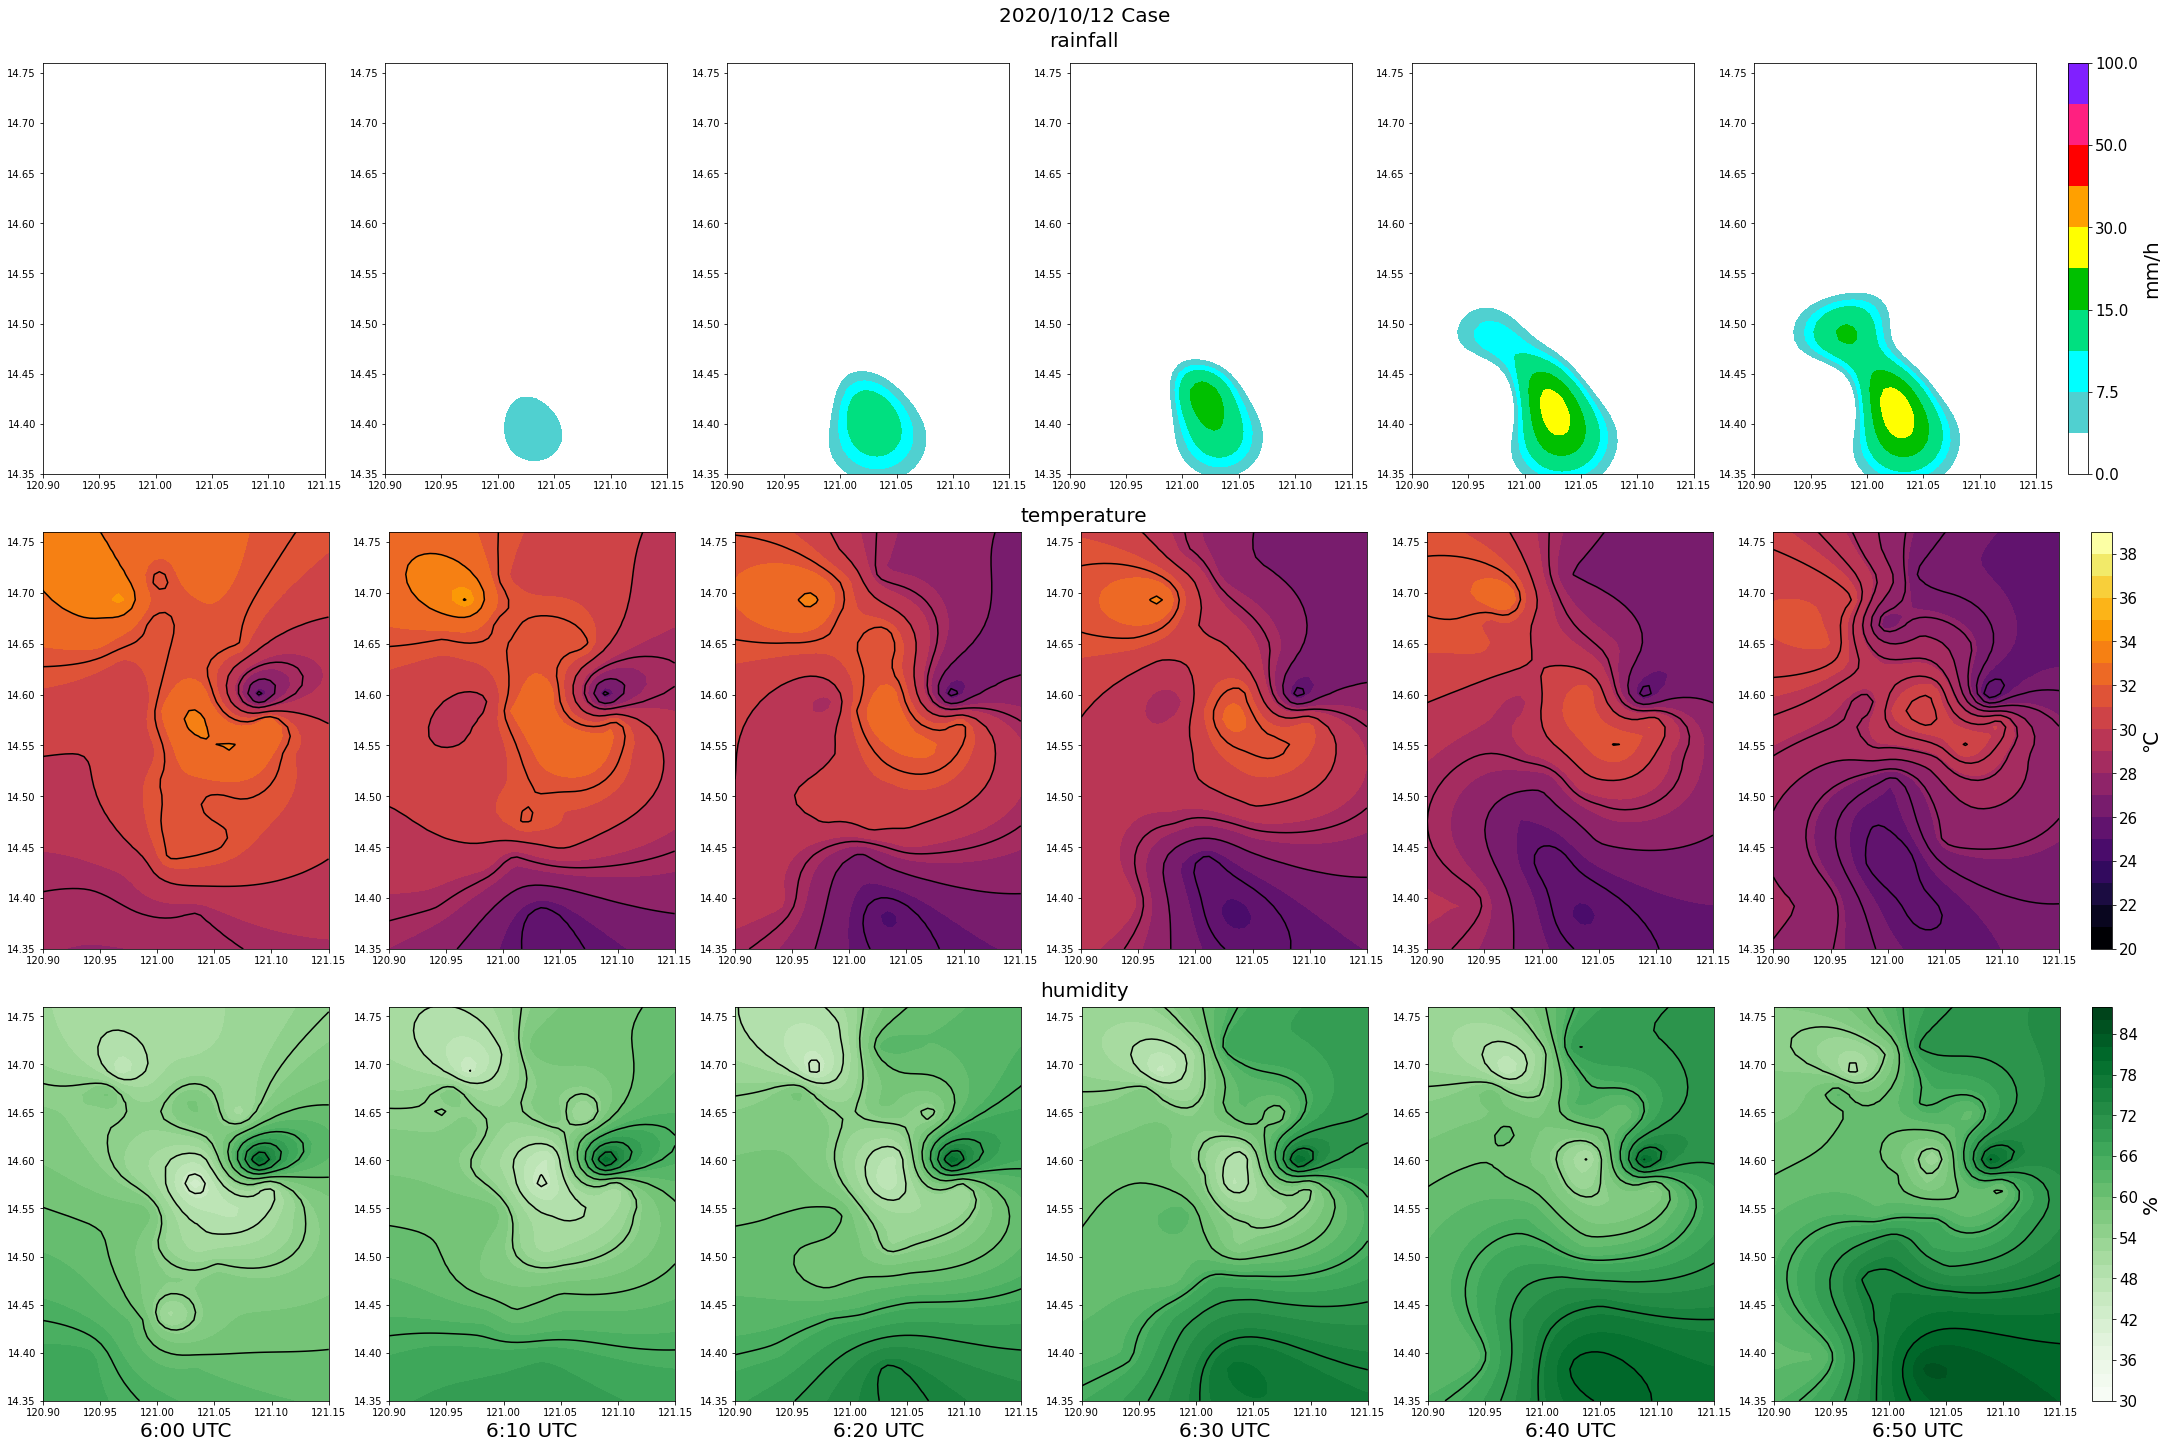

In [370]:
for test_case_name in TargetCases.good_case_names + TargetCases.bad_case_names:
    visualize_timeseries_change(test_case_name)

TC_case_2020-10-12_8-0_start


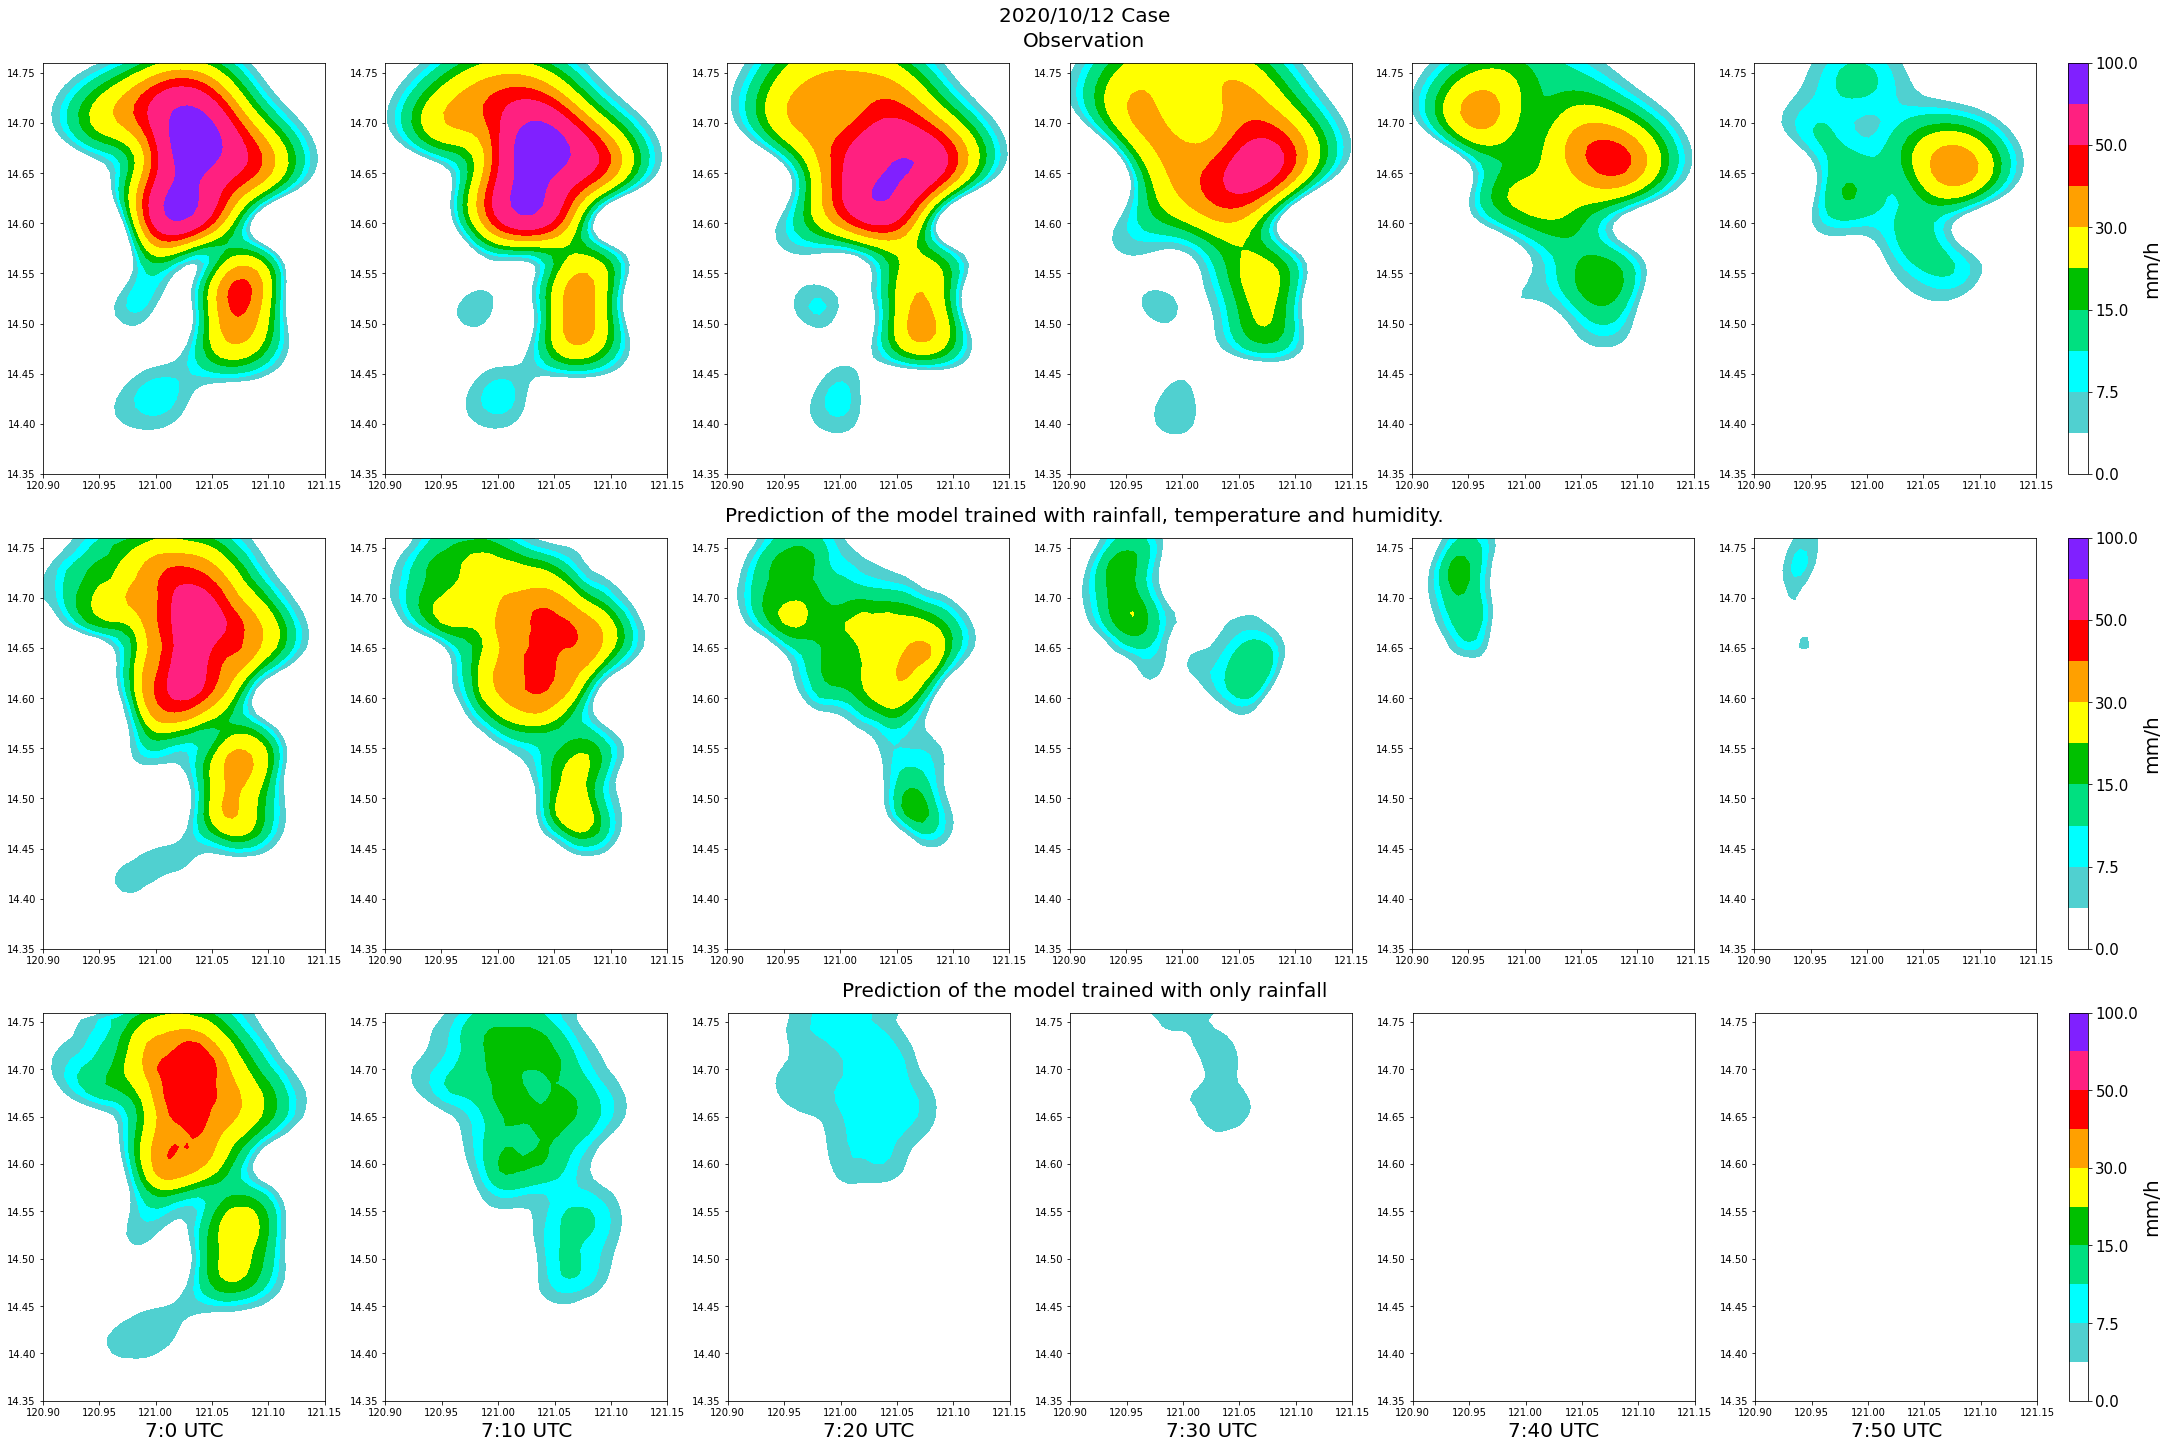

NOT_TC_case_2019-10-12_8-40_start


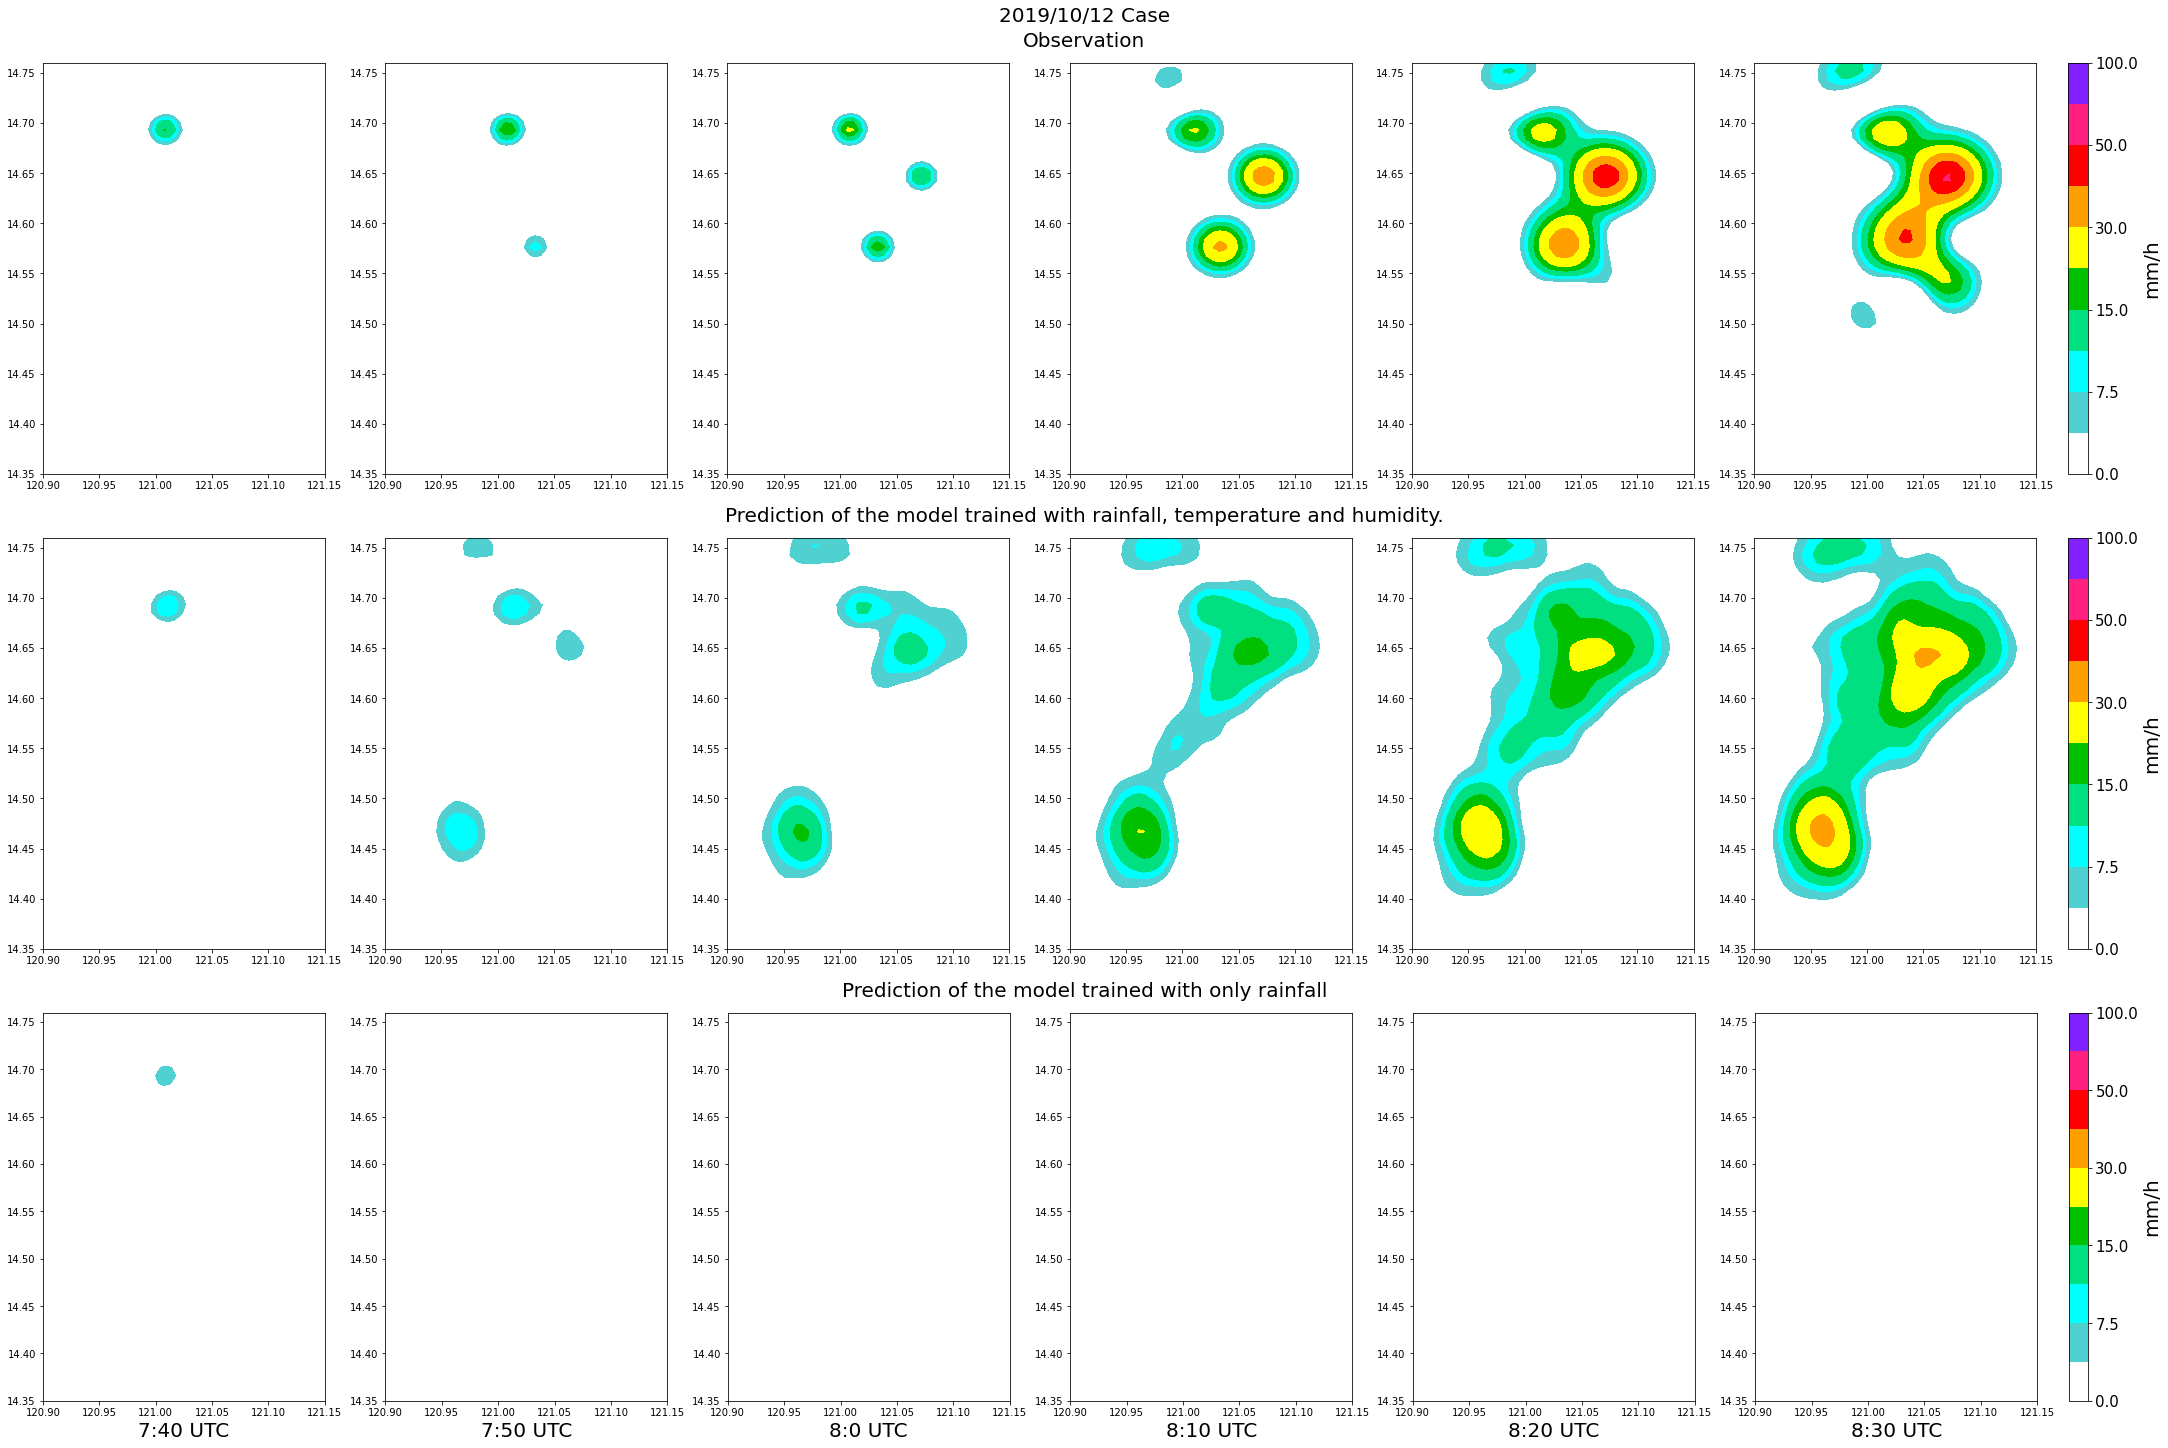

TC_case_2020-09-14_5-0_start


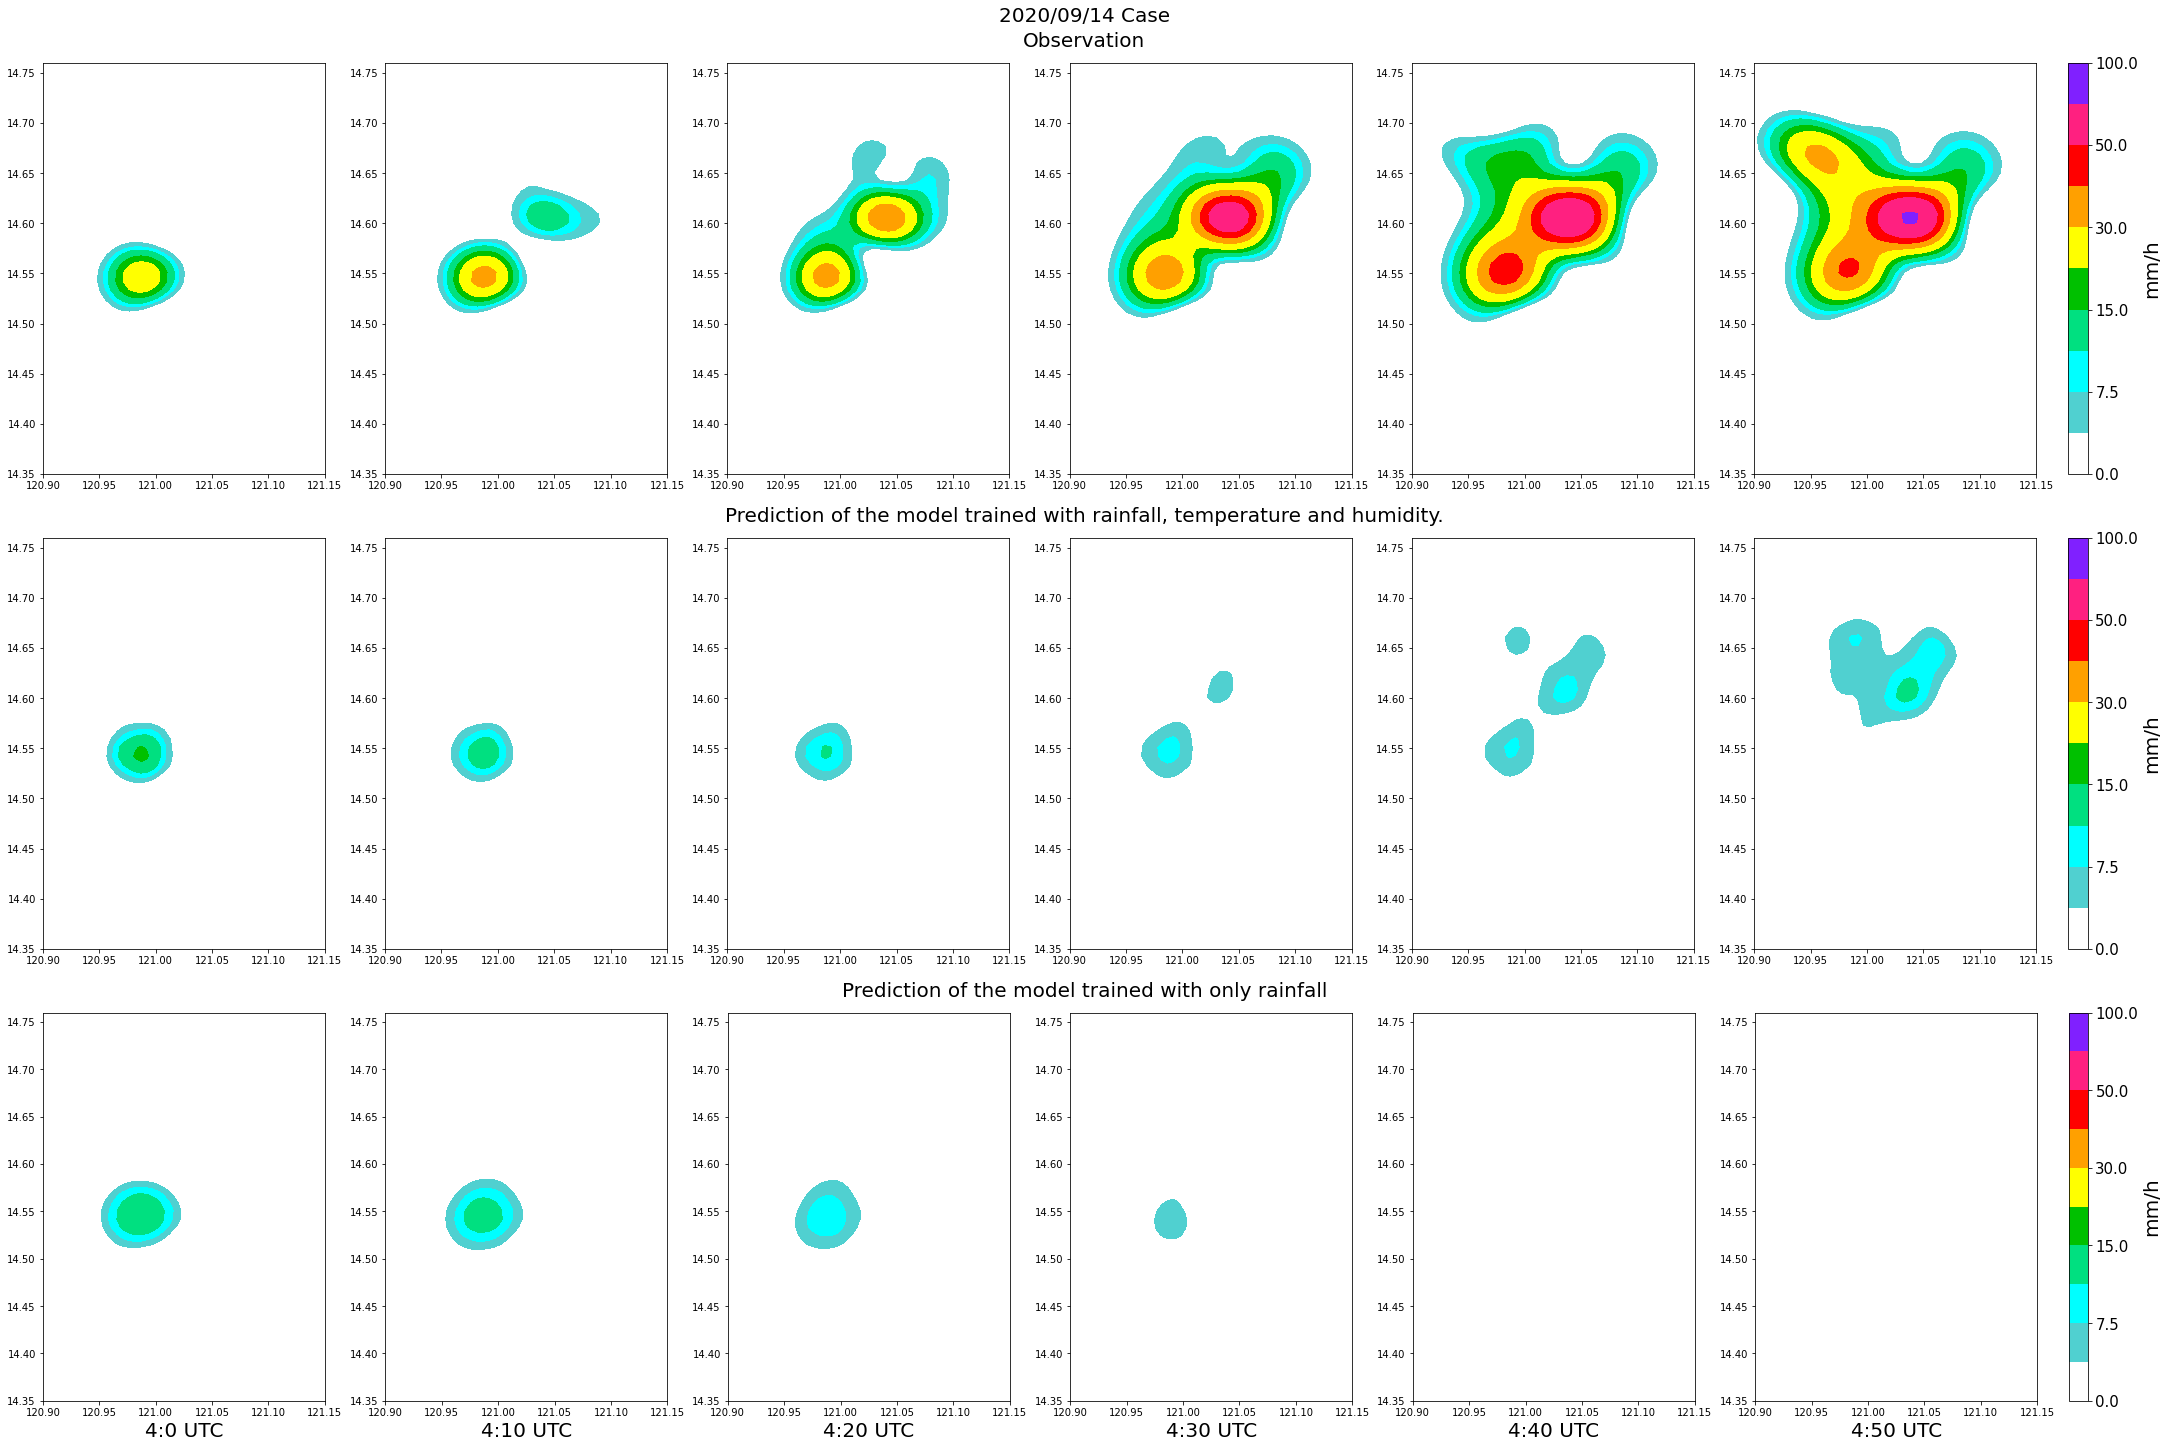

TC_case_2020-10-12_7-0_start


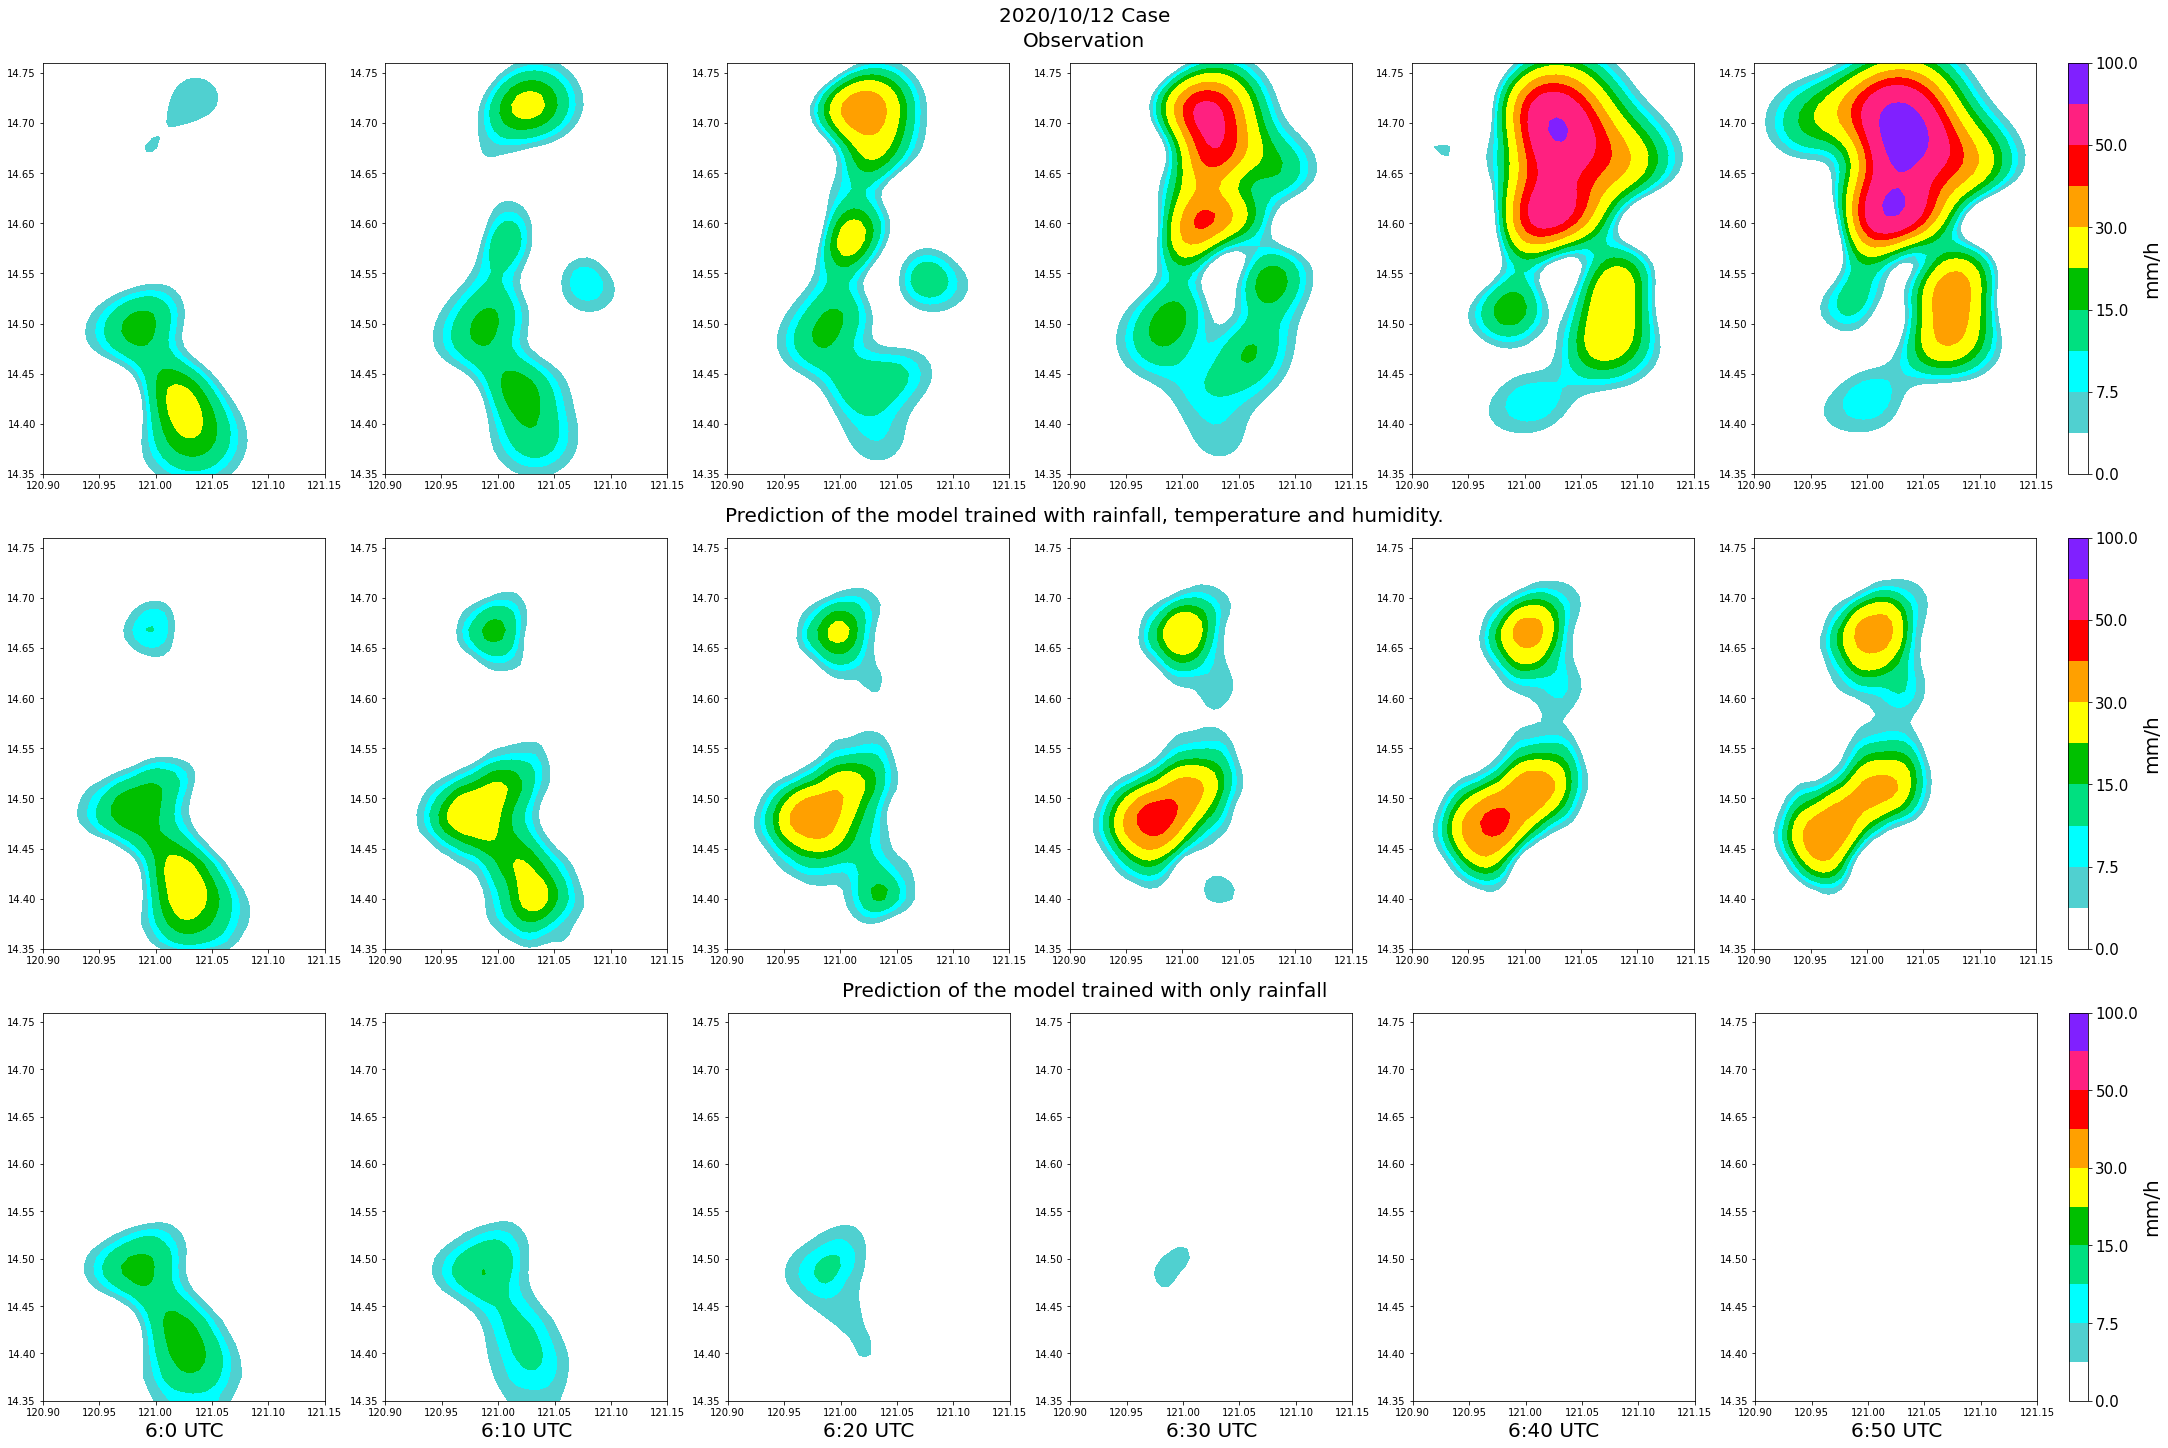

In [296]:
for test_case_name in TargetCases.good_case_names + TargetCases.bad_case_names:
    print(test_case_name)
    visualize_pred_vs_label(test_case_name)

In [67]:
def get_metrics_with_maxrainfall(run_id):
    metrics_df = get_metrics_df(run_id)
    max_rainfall = get_max_rainfalls_per_case(run_id)
    metrics_df = pd.merge(metrics_df, max_rainfall, how='left', left_on=['test_case_name', 'predict_utc_time'], right_on=['test_case_name', 'predict_utc_time'])
    return metrics_df[['test_case_name', 'predict_utc_time', 'rmse', 'max_rainfall']].sort_values(by='max_rainfall', ascending=False)